# Model to predict the Bandwidth per application

- Here the bandwidth is predicted per target/source/application

In [3]:
import pandas as pd
import pymysql
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [4]:
def connect_to_mysql():
    connection = pymysql.connect(host='10.65.47.80',
                            port=4589,
                            user='netsight',
                            password='Enterasys',
                            db='netsightrpt',
                            charset='utf8',
                            cursorclass=pymysql.cursors.DictCursor)
    return connection

conn=connect_to_mysql()

In [5]:
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

def plot_test(x,y,title1):
    #label = data.index[0:len(compare_train)]
    label1=x
    #py.init_notebook_mode
        

    # Create a trace
    
    trace1 = go.Scatter(
        x = label1,
        y = np.array(y),
        name ='Actual',
        mode = 'lines+markers'
    
        )


    # Edit the layout
    layout = dict(title = title1,
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'user_count'),
              )
    

    data = [trace1]
    fig = dict(data=data, layout=layout)
    fig =go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='basic-line')
    #py.iplot(fig, filename='jupyter/basic_bar')
  

In [6]:
def plot_test1(x,y,y2,title1):
    #label = data.index[0:len(compare_train)]
    label1=x
    #py.init_notebook_mode
        

    # Create a trace
    
    trace1 = go.Scatter(
        x = label1,
        y = np.array(y),
        name ='Actual',
        mode = 'lines+markers'
    
        )
    
    trace2 = go.Scatter(
        x = label1,
        y = np.array(y2),
        name ='Predicted',
        mode = 'lines+markers'
    
        )



    # Edit the layout
    layout = dict(title = title1,
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'user_count'),
              )
    

    data = [trace1,trace2]
    fig = dict(data=data, layout=layout)
    fig =go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='basic-line')

## 1. Fetching

In [8]:
with conn.cursor() as cursor:
        # Read a  record
        sql = "select time_stamp , application, source, target_address , application, byte_count, target_attribute_id from appid_datapoint where  application in ('Outlook', 'Microsoft Office365' , 'Skype for Business'  , 'Salesforce' ) and app_rsp_time>0 and byte_count>0"
        cursor.execute(sql)
        bw_4apps = pd.DataFrame(cursor.fetchall())
        
    

In [9]:
bw_4apps.to_csv("bw_4apps_dataset.csv",index=False)

In [7]:
bw_4apps = pd.read_csv("bw_4apps_dataset.csv")
bw_4apps = bw_4apps[bw_4apps.byte_count>0]
bw_4apps = bw_4apps.sort_values(by='byte_count')

In [8]:
#t = bw_4apps[bw_4apps.time_stamp!=1510358400000]
bw_4apps['bw'] = bw_4apps['byte_count']/(8*3600)

dates = bw_4apps.time_stamp#.astype(int)
dates_outlook =pd.to_datetime(pd.Series(dates),unit='ms')
bw_4apps.index = dates_outlook

dates_outlook[0:5]

821288    2017-12-11 09:00:00
1801304   2018-01-31 11:00:00
1180965   2017-12-23 08:00:00
1142093   2017-12-21 15:00:00
1648147   2018-01-17 12:00:00
Name: time_stamp, dtype: datetime64[ns]

In [9]:

bw_4apps.head()

,appid_datapoint.application,application,byte_count,source,target_address,target_attribute_id,time_stamp,bw
time_stamp,,,,,,,,
2017-12-11 09:00:00,Skype for Business,Skype for Business,64,10.6.1.101,134.141.200.91/,221719325,1512982800000,0.002222
2018-01-31 11:00:00,Skype for Business,Skype for Business,64,10.6.1.101,134.141.126.66/,233507605,1517396400000,0.002222
2017-12-23 08:00:00,Skype for Business,Skype for Business,64,134.141.5.104,134.141.154.22/,224851391,1514016000000,0.002222
2017-12-21 15:00:00,Skype for Business,Skype for Business,64,134.141.5.104,134.141.124.53/,224462110,1513868400000,0.002222
2018-01-17 12:00:00,Skype for Business,Skype for Business,64,10.6.1.101,134.141.172.198/,230979522,1516190400000,0.002222


In [10]:
max(bw_4apps[(bw_4apps.target_address=='10.120.89.113/') & (bw_4apps.source=='10.6.1.101') & (bw_4apps.application=='Skype for Business')].time_stamp.value_counts())

1

In [14]:
s_list=bw_4apps.source.unique()
t_list=bw_4apps.target_address.unique()
m = list()
temp = bw_4apps[bw_4apps.application=='Salesforce']
for t in t_list:
    temp1 = temp[temp.target_address==t]
    for s in s_list:
        temp2 = temp1[temp1.source==s]
        if(len(temp2>0)):
            m.append(max(temp2.time_stamp.value_counts()))
print(max(m))

1


In [11]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as mse
import math
#z1.index = z1.date
def create_prophet_m(app_name,z1):
    
    
    
    #train_end_index=int(0.7*len(data_l_ew_g1.app_rsp_time))
    train_end_index=len(z1.bw)-24
    train_df=z1.bw.iloc[0:train_end_index]
    #train_df= train_df[train_df<cutter]
    
    
    test_df=z1.bw.iloc[train_end_index:len(z1)]
    
    
    
    train_df=train_df.reset_index()
    test_df=test_df.reset_index()
    train_df.columns=['ds','y']
    
    ### --- For realtime pred ---###
    
    full_df = z1.bw.iloc[0:len(z1)]
    full_df = full_df.reset_index()
    full_df.columns = ['ds','y']
    
    q50 = full_df.y.median()
    q100 = full_df.y.quantile(1)
    q75  = full_df.y.quantile(.75)
    #print(max(full_df.y))
    if((q100-q50) >= (2*q75)):
        print('ind')
        full_df.loc[full_df.y>=(2*q75),'y'] = None
        
    
    #-- Realtime prediction --##
    #model 
    model_r = Prophet(yearly_seasonality=False,changepoint_prior_scale=.2)
    model_r.fit(full_df)
    future_r = model_r.make_future_dataframe(periods=24,freq='H')
    forecast_r = model_r.predict(future_r)
    forecast_r.index = forecast_r['ds']
    #forecast 
    pred_r = pd.DataFrame(forecast_r['yhat'][len(z1):(len(z1)+24)])
    pred_r=pred_r.reset_index()
    
    #--- removing outliers in trainset  ---#
    
    q50 = train_df.y.median()
    q100 = train_df.y.quantile(1)
    q75  = train_df.y.quantile(.75)
    print(max(train_df.y))
    if((q100-q50) >= (2*q75)):
        print('ind')
        train_df.loc[train_df.y>=(2*q75),'y'] = None
        
        print(max(train_df.y))
        print((q100-q50),(1.5*q50))
    
    
    test_df.columns=['ds','y']
    #print(train_df.tail())
    #print(test_df.head())
    
    #model 
    model = Prophet(yearly_seasonality=False,changepoint_prior_scale=.2)
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(test_df),freq='H')
    forecast = model.predict(future)
    forecast.index = forecast['ds']
    #forecast 
    pred = pd.DataFrame(forecast['yhat'][train_end_index:len(z1)])
    pred=pred.reset_index()
    pred_df=pd.merge(test_df,pred,on='ds',how='left')
    pred_df.dropna(inplace=True)
    
    df=pd.DataFrame()
    
    if(len(pred_df)>0):
        
        pred_df['error_test']=pred_df.y-pred_df.yhat
    
        t_mean =train_df.y.mean()
        pred_df['train_mean']=t_mean
        pred_df['mean_diff']= abs(pred_df.train_mean-pred_df.y)
    
        mean_mse=mse(pred_df.y,pred_df.train_mean)
        mean_RMSE=math.sqrt(mean_mse)
        pred_df['mean_APE']=abs(pred_df.mean_diff*100/pred_df.y)
        mean_MAPE=pred_df.mean_APE.mean()
    
        MSE=mse(pred_df.y,pred_df.yhat)
        RMSE=math.sqrt(MSE)
        pred_df['APE']=abs(pred_df.error_test*100/pred_df.y)
        MAPE=pred_df.APE.mean()
        print("App name:",app_name)
        print("MSE  :",MSE)
        print("RMSE :",RMSE)
        print("MAPE :",MAPE)
        #print("RMSE from mean :",mean_RMSE)
        #print("MAPE from mean :",mean_MAPE)
    
        #print(pred_df.head())
        q98=pred_df['APE'].quantile(0.98)
        mape_q98=pred_df['APE'][pred_df.APE<pred_df['APE'].quantile(0.98)].mean()

        df = pd.DataFrame({'length':len(z1),#'predicted_t':[forcast_lag],
                             'test_rmse':RMSE,
                             'test_mape':MAPE,
                 #'test_ape_98':q98,
                 'test_mape_98':mape_q98},
                      #'rmse_by_mean':mean_RMSE,
                      #'mape_by_mean':mean_MAPE}
                          index=[app_name])

    return(df,model,forecast,pred_df,pred_r)

In [12]:
bw_1app = bw_4apps[bw_4apps.application=='Skype for Business']
bw_1app.source.value_counts()

10.6.1.101         699717
134.141.5.104      469224
134.141.115.101     75908
134.141.208.230     62324
134.141.5.102       14363
134.141.121.91       2081
134.141.224.29        456
Name: source, dtype: int64

In [13]:
bw_1app_1s = bw_1app[bw_1app.source=='10.6.1.101']
bw_1app_1s.target_address.value_counts()

10.6.31.25/                                      1874
10.6.31.27/                                      1874
134.141.38.140/                                  1874
134.141.154.40/                                  1874
10.6.31.64/                                      1874
10.6.16.183/                                     1874
10.6.16.181/                                     1874
134.141.38.141/                                  1874
134.141.36.60/                                   1874
134.141.126.197/                                 1874
10.6.16.182/                                     1874
134.141.124.11/                                  1872
10.6.16.140/                                     1870
134.141.97.151/hu10061002074.global.avaya.com    1868
134.141.157.11/                                  1862
10.6.116.248/                                    1860
10.120.89.114/                                   1856
10.120.89.113/                                   1856
134.141.208.18/             

In [14]:
tt = bw_1app.target_address.value_counts()
bwvc = tt.index[0:100] 

### examples

#### 1.

In [15]:
bw_4apps = bw_4apps.sort_values(by='time_stamp')
t = '10.120.89.113/'
s = '10.6.1.101'
a = 'Skype for Business'
bw_4apps1 = bw_4apps[(bw_4apps.target_address==t) & (bw_4apps.source==s)  & (bw_4apps.application==a)]
plot_test(bw_4apps1.index,bw_4apps1.bw,'10.120.89.113/ - 10.6.1.101 - skype ')

In [17]:
ew_prophet,ew_model,ew_forcast,ew_pred_df,pred_r=(create_prophet_m('salesforce',bw_4apps1))

ind


/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



7362.395347222222
ind
2566.2603125
6579.225763888889 1174.754375
App name: salesforce
MSE  : 105669.9559907496
RMSE : 325.06915570498165
MAPE : 22.34501073295741


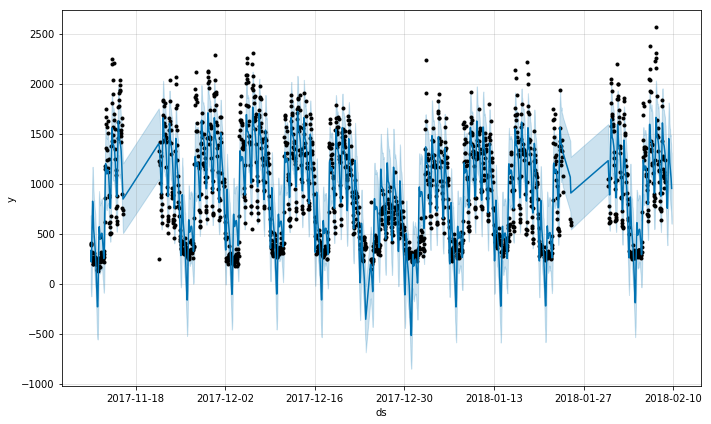

In [18]:
ew_model.plot(ew_forcast)

#### 2.

In [132]:
bw_4apps = bw_4apps.sort_values(by='time_stamp')
t = '10.6.16.181/'
s = '10.6.1.101'
a = 'Skype for Business'
bw_4apps1 = bw_4apps[(bw_4apps.target_address==t) & (bw_4apps.source==s)  & (bw_4apps.application==a)]
plot_test(bw_4apps1.index,bw_4apps1.bw,'10.120.89.113/ - 10.6.1.101 - skype ')

In [133]:
ew_prophet,ew_model,ew_forcast,ew_pred_df=(create_prophet_m('salesforce',bw_4apps1))

145588.19708333333
ind
26886.777743055554
140789.07854166668 7198.6778125


/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



App name: salesforce
MSE  : 172753330.93383232
RMSE : 13143.56614217893
MAPE : 38.07850404816028


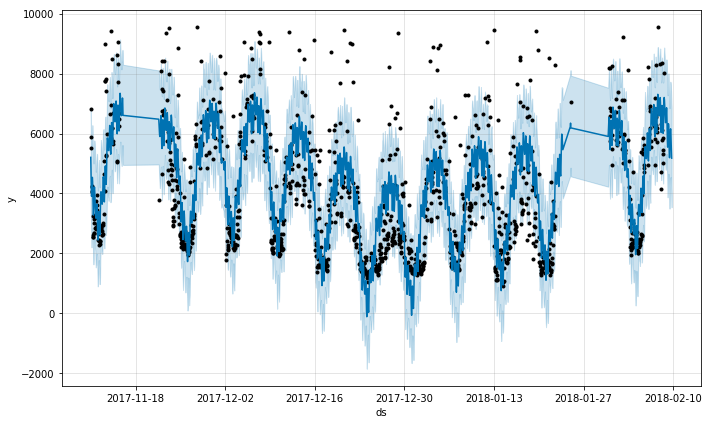

In [80]:
ew_model.plot(ew_forcast)

#### 3.

In [129]:
bw_4apps = bw_4apps.sort_values(by='time_stamp')
t = '10.6.16.216/'
s = '10.6.1.101'
a = 'Skype for Business'
bw_4apps1 = bw_4apps[(bw_4apps.target_address==t) & (bw_4apps.source==s)  & (bw_4apps.application==a)]
plot_test(bw_4apps1.index,bw_4apps1.bw,'10.120.89.113/ - 10.6.1.101 - skype ')

In [130]:
ew_prophet,ew_model,ew_forcast,ew_pred_df=(create_prophet_m('salesforce',bw_4apps1))

718.8869444444445
ind
319.1896527777778
556.1384722222222 244.12270833333335


/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



App name: salesforce
MSE  : 49.20997698102394
RMSE : 7.014982322217493
MAPE : 2.808841407205014


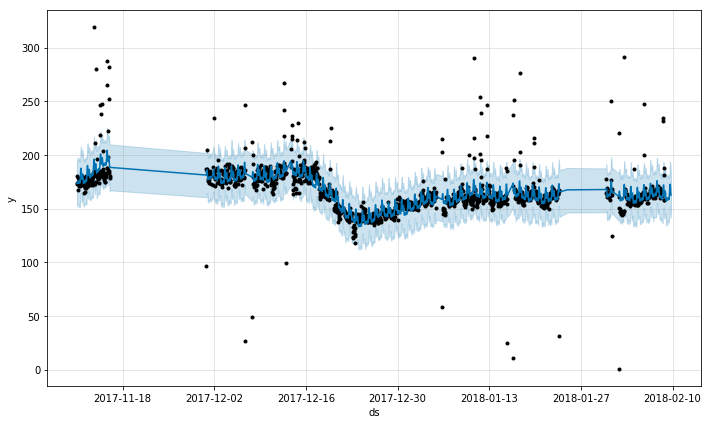

In [131]:
ew_model.plot(ew_forcast)

In [139]:
bw_4apps = bw_4apps.sort_values(by='time_stamp')
t = '134.141.36.60/'
s = '10.6.1.101'

a = 'Skype for Business'
bw_4apps1 = bw_4apps[(bw_4apps.target_address==t) & (bw_4apps.source==s)  & (bw_4apps.application==a)]
plot_test(bw_4apps1.index,bw_4apps1.bw,'10.120.89.113/ - 10.6.1.101 - skype ')

In [140]:
ew_prophet,ew_model,ew_forcast,ew_pred_df=(create_prophet_m('salesforce',bw_4apps1))

772.231875
ind
60.92076388888889
760.8829513888888 17.023385416666667


/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



App name: salesforce
MSE  : 325.5256922961169
RMSE : 18.04233056719993
MAPE : 135.19623026145416


In [141]:
    q50 = bw_4apps1.bw.median()
    q100 = bw_4apps1.bw.quantile(1)
    q75  = bw_4apps1.bw.quantile(.75)
    print("max = ",max(bw_4apps1.bw))
    print("q50 = ",q50)
    print("q75 = ",q75)
    print("q100-q50 = ",(q100-q50))
    if((q100-q50) >= (2*q50)):
        
        bw_4apps1.loc[bw_4apps1.bw>=(2*q50),'bw'] = None
        
        
    plot_test(bw_4apps1.index,bw_4apps1.bw,'10.120.89.113/ - 10.6.1.101 - skype ')

max =  772.231875
q50 =  11.501006944444445
q75 =  30.47864583333333
q100-q50 =  760.7308680555554


/root/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Run for all combinations

In [20]:

from tqdm import tqdm
prophet_df = pd.DataFrame()
prophet_analysis_df = pd.DataFrame()

temp_p = bw_4apps.sort_values(by='time_stamp').copy()
s_list = bw_4apps.source.unique()
a_list = bw_4apps.application.unique()

prophet_future_df = pd.DataFrame()
#t_list = bw_1app.target_address.unique()
for k in tqdm(range(0,len(a_list))):
    a = a_list[k]
    temp = temp_p[temp_p.application==a]

    for i in (range(0,100)):
        t = bwvc[i]
        temp1 = temp[temp.target_address==t]
        for s in s_list:
            temp2 = temp1[temp1.source==s]
            if(len(temp2)<=1400):
                continue
            ew_prophet,ew_model,ew_forcast,ew_pred_df,pred_r=(create_prophet_m('skype',temp2))
            ew_pred_df['application'] = a
            ew_pred_df['target'] = t
            ew_pred_df['source'] = s
            
            pred_r['application'] = a
            pred_r['target'] = t
            pred_r['source'] = s
            
            #ew_pred_df['attribute_id'] = temp2.iloc[(len(temp2)-len(ew_pred_df)):len(temp2),'target_attribute_id']
        
            aid = temp2.target_attribute_id.unique()
        
            conn.close()
            conn = connect_to_mysql()
            with conn.cursor() as cursor:
                # Read a  record
                sql = " select * from appid_attribute where  target_address in ( '"+t+"' ) and source='"+s+"' "
                cursor.execute(sql) 
                tt_attr = pd.DataFrame(cursor.fetchall())
            
        
            #tt_attr = appid_attribute[(appid_attribute.source==s) & (appid_attribute.target_address==t)]

            vc = tt_attr[tt_attr.attribute_id.isin(aid)].target_type.value_counts()
            ew_prophet['application'] = a
            ew_prophet['target'] = t
            ew_prophet['source'] = s
            vc_i = vc.index
            ew_prophet['SERVER_COUNT'] = None
            ew_prophet['CLIENT_COUNT'] = None
            print(max(temp2.time_stamp.value_counts()))
        
        
            for k in vc_i:
                k1 =k+'_COUNT'
                ew_prophet[k1]=vc[k]
        
        
            prophet_df = prophet_df.append(ew_pred_df)  
            prophet_analysis_df = prophet_analysis_df.append(ew_prophet)
            prophet_future_df = prophet_future_df.append(pred_r)
        
    

  0%|          | 0/4 [00:00<?, ?it/s]

ind


/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



16231.685902777777
ind
1184.3274652777777
15893.720434027777 506.948203125
App name: skype
MSE  : 18657.47797383449
RMSE : 136.59237890100053
MAPE : 36.72728881733951
1
ind
7362.395347222222
ind
2566.2603125
6579.225763888889 1174.754375
App name: skype
MSE  : 105669.9559907496
RMSE : 325.06915570498165
MAPE : 22.34501073295741
1
ind
18.694652777777776
ind
12.600069444444445
14.61815972222222 6.114739583333334
App name: skype
MSE  : 1.2682135887961132
RMSE : 1.1261498962376693
MAPE : 15.96395217664132
1
ind
82952.04440972222
ind
5387.829409722222
81648.58107638889 1955.1950000000002
App name: skype
MSE  : 9667728.082354309
RMSE : 3109.297039903764
MAPE : 40.459897962272386
1
ind
180848.50496527777
ind
29124.736458333333
175804.2931770833 7566.317682291668
App name: skype
MSE  : 82084799.50899564
RMSE : 9060.06619782635
MAPE : 45.10991523441816
1
ind
80817.00791666667
ind
4919.260416666667
79628.58939236111 1782.627786458333
App name: skype
MSE  : 4627897.435095294
RMSE : 2151.254851265

App name: skype
MSE  : 1292.469212362246
RMSE : 35.950927837292966
MAPE : 11.098312987426963
1
397.9889236111111
App name: skype
MSE  : 1226.60102860735
RMSE : 35.02286436897116
MAPE : 10.81883565442547
1
ind
718.8869444444445
ind
319.1896527777778
556.1384722222222 244.12270833333335
App name: skype
MSE  : 49.20997698102394
RMSE : 7.014982322217493
MAPE : 2.808841407205014
1
ind
5949.432083333333
ind
3047.2534375
5044.290208333333 1357.7128125
App name: skype
MSE  : 448767.12905260024
RMSE : 669.9008352380225
MAPE : 29.964999474835007
1
ind
258.6437847222222
ind
72.87618055555555
231.83291666666668 40.21630208333333
App name: skype
MSE  : 192.3569956067714
RMSE : 13.869282447436543
MAPE : 26.550738194509027
1
ind
145.94684027777777
ind
51.09413194444444
120.54868055555555 38.097239583333334
App name: skype
MSE  : 169.47474414267558
RMSE : 13.01824658480072
MAPE : 13.053316778708979
1


 25%|██▌       | 1/4 [10:44<32:13, 644.43s/it]

ind
20154.692361111112
ind
8569.492569444445
17540.916163194444 3920.664296875
App name: skype
MSE  : 2571315.9786368012
RMSE : 1603.53234411932
MAPE : 32.80454724273254
1
ind
21990.418993055555
ind
8403.435763888889
19346.95064236111 3965.202526041667
App name: skype
MSE  : 2165604.6194337453
RMSE : 1471.599340660951
MAPE : 31.4975499822983
1
ind
31.212118055555557
ind
4.610833333333333
28.907812500000002 3.4564583333333334
App name: skype
MSE  : 0.2020833930294977
RMSE : 0.4495368650394511
MAPE : 18.007668166931744
1


100%|██████████| 4/4 [11:25<00:00, 171.31s/it]


In [23]:
prophet_analysis_df.to_csv('bw_analysis_per_target_per_source_per_app_data.csv',index=False)

In [24]:
prophet_df.to_csv('bw_evaluation_per_target_per_source_per_app_data.csv',index=False)
prophet_future_df.to_csv('bw_forecast_per_target_per_source_per_app_data.csv',index=False)

In [25]:
prophet_analysis_df.sort_values(by='test_mape')

,length,test_mape,test_mape_98,test_rmse,application,target,source,SERVER_COUNT,CLIENT_COUNT
skype,1589,2.440491,2.298268,1.740192,Skype for Business,134.141.43.236/,10.6.1.101,1578,8
skype,1552,2.808841,2.397713,7.014982,Skype for Business,10.6.16.216/,10.6.1.101,1325,224
skype,1839,4.726887,4.267218,7.813644,Skype for Business,10.6.112.46/,10.6.1.101,727,1109
skype,1870,5.256165,4.951740,19.318006,Skype for Business,10.6.16.140/,10.6.1.101,None,1867
skype,1868,7.929222,7.401045,0.612178,Skype for Business,134.141.97.151/hu10061002074.global.avaya.com,10.6.1.101,2,1863
skype,1860,9.022618,8.296299,14.039319,Skype for Business,10.6.116.248/,10.6.1.101,1780,77
skype,1855,9.034137,8.354863,0.587673,Skype for Business,134.141.208.18/,10.6.1.101,1830,22
skype,1903,9.406343,7.687020,1.868748,Skype for Business,134.141.97.151/hu10061002074.global.avaya.com,134.141.5.104,10,1893
skype,1874,9.600331,9.091183,0.503133,Skype for Business,134.141.38.141/,10.6.1.101,1867,4
skype,1872,9.736968,9.013167,14.971994,Skype for Business,134.141.124.11/,10.6.1.101,3,1866


In [26]:
prophet_analysis_df_final = prophet_analysis_df[prophet_analysis_df.source!='134.141.5.104'].sort_values(by='test_mape')

In [27]:
prophet_analysis_df_final.to_csv('bw_analysis_per_target_per_source_per_app_data.csv',index=False)

### Plots

In [29]:
t = '134.141.43.236/'
s = '10.6.1.101'
a = 'Skype for Business'

tt = prophet_df[(prophet_df.source==s) & (prophet_df.target==t) &(prophet_df.application==a)]
plot_test1(tt.ds,tt.y,tt.yhat,'134.141.5.104')

In [137]:
t = '134.141.36.60/'
s = '10.6.1.101'

tt = prophet_df[(prophet_df.source==s) & (prophet_df.target==t)]
plot_test1(tt.ds,tt.y,tt.yhat,'134.141.5.104')

In [138]:
t = '10.120.89.113/'
s = '10.6.1.101'

tt = prophet_df[(prophet_df.source==s) & (prophet_df.target==t)]
plot_test1(tt.ds,tt.y,tt.yhat,'134.141.5.104')